In [23]:
import numpy as np
from numba import vectorize
import matplotlib.pyplot as plt
import torch
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj')
from dft3dgpu import dft3d

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-04-27

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='NVIDIA GeForce GTX 1050 Ti', major=6, minor=1, total_memory=4036MB, multi_processor_count=6)


In [25]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

# Defining the fluid properties

In [26]:
# fluid properties
sigma = 1.0
epsilon = 1.0
L = 11.0*sigma
# Temperature and Density 
kT = 2.934
rhob = 0.450

# Defining the functional 


In [27]:
# Test the HS functional 
Ngrid = 128
DFT = dft3d(gridsize=(Ngrid,Ngrid,Ngrid),ljmethod='MMFA')
DFT.Set_Geometry(L=L)
DFT.Set_FluidProperties(sigma=sigma,epsilon=epsilon)
DFT.Set_Temperature(kT)
DFT.Set_BulkDensity(rhob)

In [28]:
DFT.delta

array([0.0859375, 0.0859375, 0.0859375])

In [29]:
R = np.sqrt(DFT.X**2+DFT.Y**2+DFT.Z**2+1e-16)
Vext = ljpotential(R,epsilon,sigma)
DFT.Set_External_Potential(Vext)

del R

(-5.54296875, 5.45703125, -5.54296875, 5.45703125)

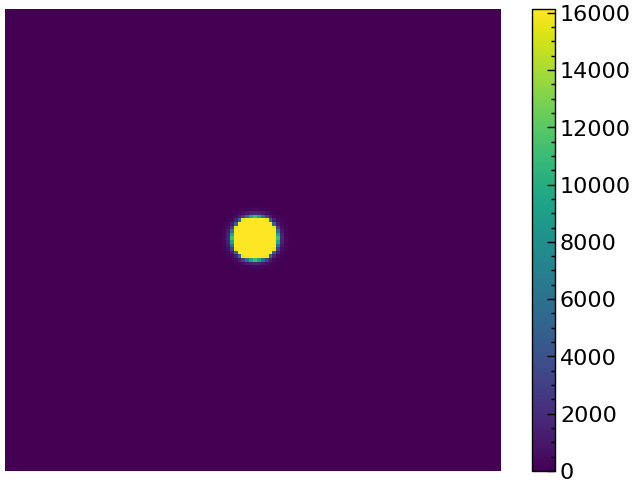

In [30]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis')
plt.colorbar(c)
plt.axis('off')

## Setting the Initial Condition

In [31]:
DFT.Set_InitialCondition()

In [32]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.4500))

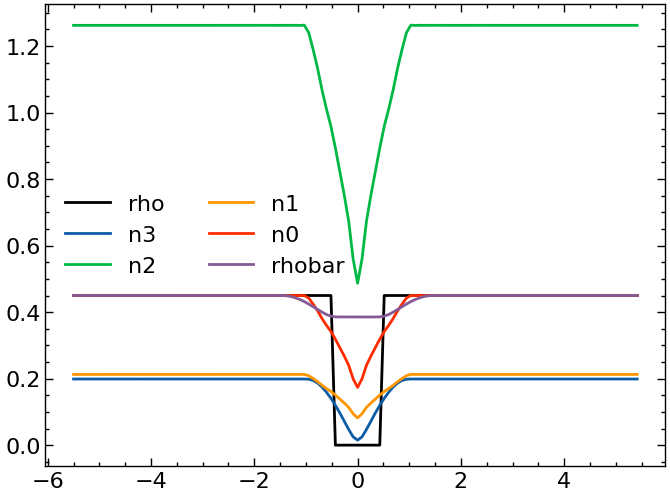

In [33]:
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rho[:,Ngrid//2,Ngrid//2].numpy(),color='k',label='rho')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n3[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n3')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n2[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n2')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n1[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n1')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.n0[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='n0')
plt.plot(DFT.X[:,Ngrid//2,Ngrid//2],DFT.rhobar[:,Ngrid//2,Ngrid//2].cpu().numpy(),label='rhobar')
plt.legend(loc='best',ncols=2)

## Calculate Equilibrium

In [34]:
# DFT.Calculate_Equilibrium(alpha0=0.6,rtol=1e-1,atol=1e-2,max_iter=15,method='picard',logoutput=True)
DFT.Calculate_Equilibrium(alpha0=0.25,dt=0.5,rtol=1e-3,atol=1e-4,method='fire',logoutput=True)

0 -1072.1987 37077.08
1 -2416.032 115.74786
2 -2418.9268 22.620314
3 -2419.2334 15.643081
4 -2416.9956 66.237465
5 -2419.1882 18.455128
6 -2419.1824 19.564396
7 -2419.2913 11.79846
8 -2419.2793 13.068745
9 -2419.284 12.673375
10 -2419.3552 2.8816054
11 -2419.3108 10.060517
12 -2387.0667 342.8633
13 -2418.947 30.33845
14 -2416.2915 75.831055
15 -2417.6833 55.916576
16 -2417.5835 57.946907
17 -2419.335 6.3356404
18 -2417.9827 57.052265
19 -2419.2744 13.790587
20 -2419.2422 15.695145
21 -2419.356 2.2761636
22 -2419.3481 4.907666
23 -2419.3572 1.9742897
24 -2419.3462 5.296924
25 -2419.353 3.5630949
26 -2419.3562 2.3655536
27 -2419.359 0.76434344
Time to achieve equilibrium: 52.89965236300486 sec
Number of iterations: 27
error: 0.76434344
---- Equilibrium quantities ----
Fid = -3154.297
Fexc = 144.69958
Omega = -2419.359
Nbulk = 598.95
Nadstot = 598.3273


In [35]:
DFT.Niter

27

In [36]:
DFT.rho.min(),DFT.rho.max()

(tensor(0.), tensor(0.7318))

In [37]:
DFT.Omega

tensor(-2419.3589)

(-5.54296875, 5.45703125, -5.54296875, 5.45703125)

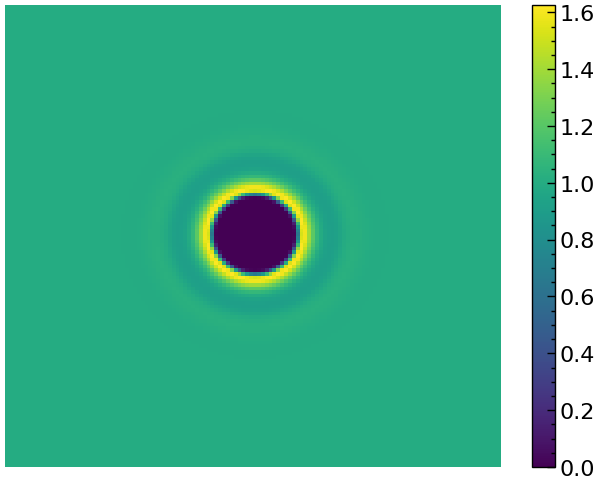

In [38]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.rho[:,:,Ngrid//2].numpy()/rhob, cmap='viridis')
plt.colorbar(c)
plt.axis('off')

In [39]:
np.save(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid={Ngrid}-ljmethod={DFT.ljmethod}.npy',(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob))

In [40]:
zwda,rhowda = np.load(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid=128-ljmethod=WDA.npy')
zmmfa,rhommfa = np.load(f'radialdistribution-3D-rhob={rhob}-kT={kT}-Ngrid=128-ljmethod=MMFA.npy')

## Plotting g(r)

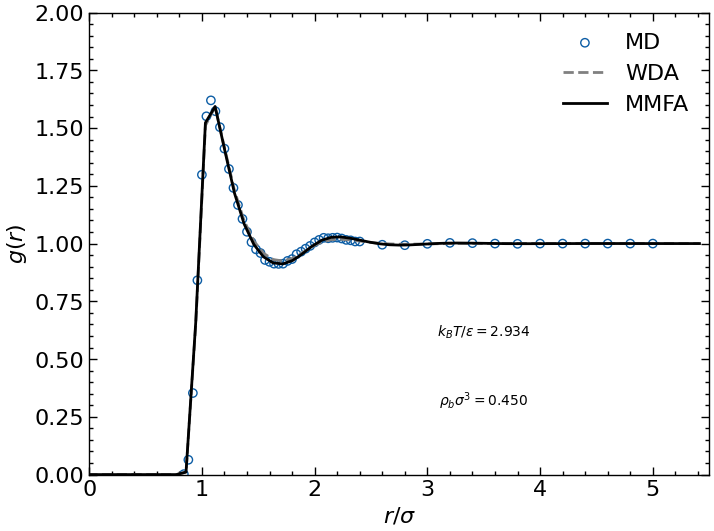

In [46]:
import pandas as pd
df = pd.read_excel('data/MC/MCdata-radialdistribution-lennardjones-Verlet1968.xls',sheet_name='rhob=0.450')
plt.scatter(df['r'],df['KT=2.934'],marker='o',edgecolors='C0',facecolors='none',label='MD')
plt.plot(zwda,rhowda,'--',color='grey',label=r'WDA')
plt.plot(zmmfa,rhommfa,'-',color='k',label=r'MMFA')
# plt.plot(DFT.Z[Ngrid//2,Ngrid//2,:],DFT.rho[Ngrid//2,Ngrid//2,:].numpy()/rhob,'-',color='k',label=r'3D-DFT')
plt.xlim(0.0,5.5)
plt.ylim(0,2.0)
plt.xlabel(r'$r/\sigma$')
plt.ylabel(r'$g(r)$')
plt.text(3.5,0.6,r'$k_B T/\epsilon = 2.934$',ha='center')
plt.text(3.5,0.3,r'$\rho_b \sigma^3 = 0.450$',ha='center')
plt.legend(loc='upper right',ncol=1)